In [1]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
import sys
import os
from pathlib import Path

# Add parent directory temporarily to sys.path
sys.path.insert(0, str(Path(os.getcwd()).resolve().parent))

In [3]:
from __future__ import annotations
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from lib.State import State

from tqdm.notebook import tqdm

from lib.utils.utils import *

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:

Nx = 512
Ny = 512

Lx = 50
Ly = 50
T_end = 1
dt = 0.002

myubatch_size = 65536

myu=4
path = f"main-gpu-N-{Nx}-L-{Lx}-Myu-{myu}"
mtlibpath_prefix = path + "_mtl"
model_filepath = f"./models/{path}.pt"

is_simulation = False

input_to_defect_ratio_sqrt = Nx // myu
N_ITERATIONS = int(T_end / dt)
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=input_to_defect_ratio_sqrt*input_to_defect_ratio_sqrt, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=20, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

100%|██████████| 500/500 [00:48<00:00, 10.31it/s]


Unique Myus count	 400
Max value of myu:	 121.80390600745552
Min value of myu:	 21.841687164812154
Unique values: [21.841687164812154, 23.009040191453206, 27.58798095569376, 28.596628485566292, 29.813741848646277, 29.827199100610592, 31.065071505241868, 31.603009497495837, 31.88124086517815, 33.61431686156065, 34.17041925745116, 34.21923912649841, 34.375065800420124, 34.48106132581881, 34.56093676069717, 35.09174364784749, 35.60701686454186, 35.68218877373676, 35.85886076968288, 35.85937948840952, 35.896216473141834, 36.75494158224988, 37.02864287053089, 37.04622304666243, 37.19247013241883, 37.24931298816487, 37.359270372192285, 37.36554733180018, 37.52804379074024, 37.57260175431684, 37.9001300899777, 38.2547862344231, 38.27347312162001, 38.88654669848664, 39.519916759125124, 39.604999555974324, 39.9231756933596, 40.403393621893414, 40.427156868939136, 40.478853264411924, 40.68736914752687, 40.70708381075805, 40.77070731420898, 41.77596767584717, 41.822325333468235, 42.22103430511227

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

In [5]:
x = np.linspace(-2, 2, Nx).flatten()[:, None]
y = np.linspace(-2, 2, Ny).flatten()[:, None]
t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

Exact = A_original.squeeze(0)

X, T, Y = np.meshgrid(x, t, y)

state_simulation = State(state = A_original[0], xyt = np.array([X, Y, T]))
MS = np.abs(A_original)**2
RI = np.real(A_original)*np.imag(A_original)
state_experiment = State(state = (MS + RI*1j)[0], xyt = np.array([X, Y, T]))


$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [6]:
from itertools import chain
from lib.nn.nets import FCN, XFCN
from lib.nn.nets import XFCN
from lib.nn.helper import BatchProcessing, SaveLoad
from lib.CGL import MYULOSS, free_memory

class ALLINPUTNET(XFCN, nn.Module, BatchProcessing, SaveLoad):
    pass

In [7]:

class PINN(ALLINPUTNET):
    def __init__(self,*args, device = 'cpu', **kwargs):
        super(PINN, self).__init__(*args, device = device, **kwargs)
        self.device = device 
        self.myureset()
        self.myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=0.01)

    
    def myureset(self):
        myu = torch.randn(mem_rate, Nx//input_to_defect_ratio_sqrt, Ny//input_to_defect_ratio_sqrt, dtype=torch.float32).to(self.device)
        myu = nn.Parameter(myu)
        self.myuparam = myu
        
    @property
    def myu(self):
        myu = F.interpolate(self.myuparam.unsqueeze(0), scale_factor=input_to_defect_ratio_sqrt, mode='nearest').squeeze()
        return myu
    
    def loaddata_precalculate(self,state):
        myuloss = MYULOSS.MYUCACHE(self, state)
        myuloss.calculate_f_withoutmyu(batch_size = myubatch_size)
        self.myuloss = myuloss
    
    def fmsef(self, myu):
        return self.myuloss.fmse(myu)
    
    def fmse(self):
        return self.fmsef(self.myu)
    
    def myu_train(self, epochs=100, lr = 0.01):
        
        myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=lr ) 
        myuoptimizer.zero_grad()

        for _ in tqdm(range(epochs)):
            self.fmse().backward(retain_graph=True)
            myuoptimizer.step()
            myuoptimizer.zero_grad()
        
        FMSE = self.myuloss.FMSE
        self.myuloss.clear()
        return FMSE


    def myu_mse_batch_train(self, state, epochs = 100, batch_size = 64, verbose = 2, is_simulation = False):
        L = []
        for s in state.generate_batches(nbatches = epochs, batch_size = batch_size, verbose = verbose):
            s.myu = self.myu.flatten()[s.shuffled_indices][s.slice]
            self.optimizer.zero_grad()
            self.myuoptimizer.zero_grad()
            y = s.get_2d_tensor_state().T
            f, y_pred = MYULOSS.net_f(self,s)
            MS, RI = self.msef(
                    y_pred if is_simulation else ALLINPUTNET.y_proc(y_pred)
                ,y)
            FMSE = torch.mean(torch.abs(f) ** 2) / torch.mean(y_pred**2)
            L.append(
                (MS.cpu().detach().numpy(),
                RI.cpu().detach().numpy(),
                FMSE.cpu().detach().numpy())
                )
            (FMSE + MS + RI).backward(retain_graph=True)
            self.optimizer.step()
            self.myuoptimizer.step()
            free_memory(FMSE, MS, RI, f, y_pred)

        return np.array(L)

    def myu_only_mse_batch_train(self, state, epochs = 100, batch_size = 64, verbose = 2, is_simulation = False):
        L = []
        for s in state.generate_batches(nbatches = epochs, batch_size = batch_size, verbose = verbose):
            self.myuoptimizer.zero_grad()
            f, y_pred = MYULOSS.net_f(self,s)
            y = s.get_2d_tensor_state().T
            FMSE = torch.mean(torch.abs(f) ** 2)
            FMSE.backward(retain_graph=True)
            MS, RI = self.msef(
                 y_pred if is_simulation else ALLINPUTNET.y_proc(y_pred)
                ,y)
            L.append(
                (MS.cpu().detach().numpy(),
                RI.cpu().detach().numpy(),
                FMSE.cpu().detach().numpy())
                )
            self.myuoptimizer.step()
            free_memory(FMSE, MS, RI, f, y_pred)

        return np.array(L)
    

## Training the model and get approximate myus

In [8]:
torch.manual_seed(0)
net = PINN([3, 128, 128, 128, 2]).to(device)
net.device = device

state = state_simulation if is_simulation  else state_experiment


In [9]:
net.optimizer.param_groups[0]['lr'] = 1e-2
L = net.mse_batch_train(state = state, epochs = 10000, batch_size = 65536, is_simulation = is_simulation, verbose = 1, device = device)


100%|██████████| 10000/10000 [01:52<00:00, 88.92it/s]


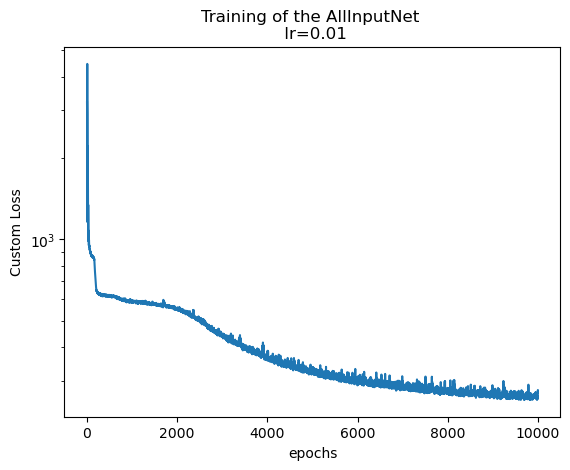

In [10]:
plt.plot(L.sum(axis=1))
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.01')
plt.savefig(f'{mtlibpath_prefix}_allinputnet001.png')

In [11]:
net.optimizer.param_groups[0]['lr'] = 1e-3
L = net.mse_batch_train(state = state, epochs = 10000, batch_size = 65536, is_simulation = is_simulation, verbose = 1, device = device)


100%|██████████| 10000/10000 [01:50<00:00, 90.28it/s]


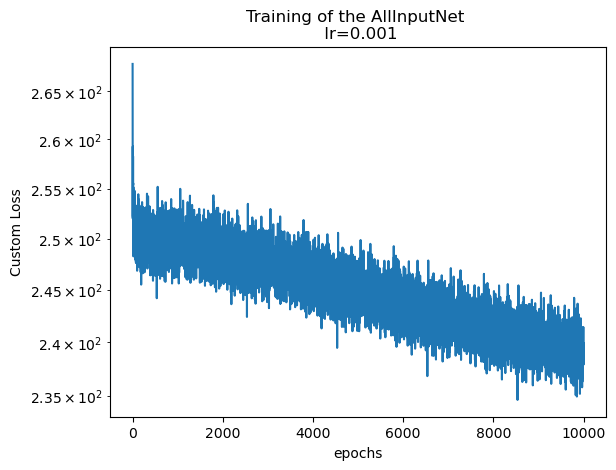

In [12]:
plt.plot(L.sum(axis=1))
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.001')
plt.savefig(f'{mtlibpath_prefix}_allinputnet0001.png')

## calculating myus

In [13]:
torch.cuda.empty_cache()

net = net.to(device)
net.loaddata_precalculate(state)


Processed up to index 131072000: 100%|██████████| 2000/2000 [03:54<00:00,  8.53it/s]


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


tensor([[ 78.5378, 118.9394,  97.2482, 104.5975],
        [121.6334, 117.9047, 112.7482,  92.1196],
        [112.0099, 113.3489, 118.6969, 114.8341],
        [101.5839, 117.0454, 104.9595,  68.6575]], device='cuda:0',
       grad_fn=<SelectBackward0>)


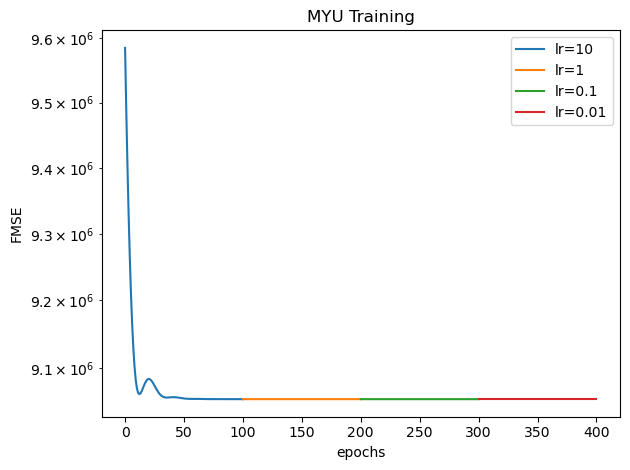

In [14]:
i = 0
for lr in [10,1,1e-1,1e-2]:
    L = net.myu_train(lr=lr, epochs=100)    
    l = net.fmse().cpu().detach().numpy()
    L += [l]
    net.myuloss.clear()
 
    plt.plot(range(i,i+len(L)), L, label=f'lr={lr}')
    i+=len(L)-1
    
print(net.myuparam[-1])

plt.yscale('log')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('FMSE')
plt.title('MYU Training')
plt.tight_layout()
plt.savefig(f'{mtlibpath_prefix}_myutraining.png')
plt.show()

## Visualizing and saving plot gifs

In [15]:
module_sq = lambda a: np.real(a)**2 + np.imag(a)**2
phase = lambda a: np.arcsin(np.real(a)/np.sqrt(np.real(a)**2+np.imag(a)**2))
real_imag = lambda a: np.real(a)*np.imag(a)
real = lambda a: np.real(a)
imag = lambda a: np.imag(a)

funlist_name = ["module_sq", "phase","real_imag","real","imag"]
funlist = [module_sq, phase, real_imag, real, imag]

myu = myu_original[0]
myupred = net.myu.cpu().detach().numpy()

A_pred = net.batch_predict(state.flatten().get_2d_tensor_xyt(device = device).T).reshape(A_original[0].shape)

In [16]:
ATenzor = np.array([np.stack([
                    np.stack([fun(A) for fun in funlist]),
                    np.stack([fun(Ap) for fun in funlist])
                    ]) for A, Ap in zip(A_original[0], A_pred)])
                    

In [17]:
MTenzor = np.array([np.array([m,mp]) for m, mp in zip(myu,myupred)])

In [18]:
AMTenzor = np.concatenate((MTenzor[:, :, np.newaxis, :, :], ATenzor), axis=2)

In [19]:
from lib.Video import create_video
create_video(AMTenzor, titles=[['myu'] + funlist_name] * 2, videotitle = path+'.mp4')

Video successfully saved at main-gpu-N-512-L-50-Myu-4.mp4
